Here, we will train an Variational Autoencoder Neural Network (implemented in Keras) in purely unsupervised fashion for Anomaly Detection in credit card transaction data. The brief work plan is given below for building the VAE model:

* Scale the input features.
* Create, and train variational autoencoder, that decode the data into a 2 dimentional latent space.
* View the data in the latent 2D space, and check classification strategies.

Reference: https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

Difference between AE & VAE: https://blog.keras.io/building-autoencoders-in-keras.html

An intuitive understanding of variational autoencoders: https://hsaghir.github.io/data_science/denoising-vs-variational-autoencoder/

#### Why VAE?

VAE is a framework that was proposed as a scalable way to do variational EM (or variational inference in general) on large datasets. Although it has an AE like structure, it serves a much larger purpose.

Having said that, one can, of course, use VAEs to learn latent representations. VAEs are known to give representations with disentangled factors [1] This happens due to isotropic Gaussian priors on the latent variables. Modeling them as Gaussians allows each dimension in the representation to push themselves as farther as possible from the other factors. Also, [1] added a regularization coefficient that controls the influence of the prior.

While isotropic Gaussians are sufficient for most cases, for specific cases, one may want to model priors differently. For example, in the case of sequences, one may want to define priors as sequential models [2].

Now, as one can see, prior gives significant control over how we want to model our latent distribution. This kind of control does not exist in the usual AE framework. This is actually the power of Bayesian models themselves, VAEs are simply making it more practical and feasible for large-scale datasets. So, to conclude, if you want precise control over your latent representations and what you would like them to represent, then choose VAE. Sometimes, precise modeling can capture better representations as in [2]. However, if AE suffices for the work you do, then just go with AE, it is simple and uncomplicated enough. After all, with AEs we are simply doing non-linear PCA.

[1] Early Visual Concept Learning with Unsupervised Deep Learning, 2016 
Irina Higgins, Loic Matthey, Xavier Glorot, Arka Pal, Benigno Uria, Charles Blundell, Shakir Mohamed, Alexander Lerchner 
https://arxiv.org/abs/1606.05579

[2] A Recurrent Latent Variable Model for Sequential Data, 2015 
Junyoung Chung, Kyle Kastner, Laurent Dinh, Kratarth Goel, Aaron Courville, Yoshua Bengio 
https://arxiv.org/abs/1506.02216

Choosing the distribution of the code in VAE allows for a better unsupervised representation learning where samples of the same class end up close to each other in the code space. Also this way, finding a semantic for the regions in the code space becomes easier. E.g, you would know from each area what class can be generated.

If you need more in-depth analysis, have a look at Durk Kingma' thesis. It's a great source for variational inference.

#### Intuitive understanding of variational autoencoders:

A typical autoencoder can usually encode and decode data very well with low reconstruction error, but a random latent code seems to have little to do with the training data. In other words the latent code does not learn the probability distribution of the data and therefore, if we are interested in generating more data like our dataset a typical autoencoder doesn’t seem to work as well. There is however another version of autoencoders, called “variational autoencoder - VAE” that are able to solve this problem since they explicitly define a probability distribution on the latent code. The neural network architecture is very similar to a regular autoencoder but the difference is that the hidden code comes from a probability distribution that is learned during the training.
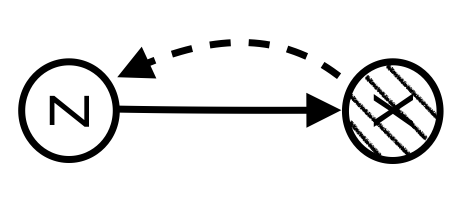
A variational autoencoder is essentially a graphical model similar to the figure above in the simplest case. We assume a local latent variable, Zi for each data point Xi. The inference and data generation in a VAE benefit from the power of deep neural networks and scalable optimization algorithms like SGD.

As can be seen from the picture above, in a VAE, the encoder becomes a variational inference network that maps the data to the a distribution for the hidden variables, and the decoder becomes a generative network that maps the latent variables back to the data. Since the latent variable is actually a probability distribution, we need to sample the hidden code from its distribution to be able to generate data.

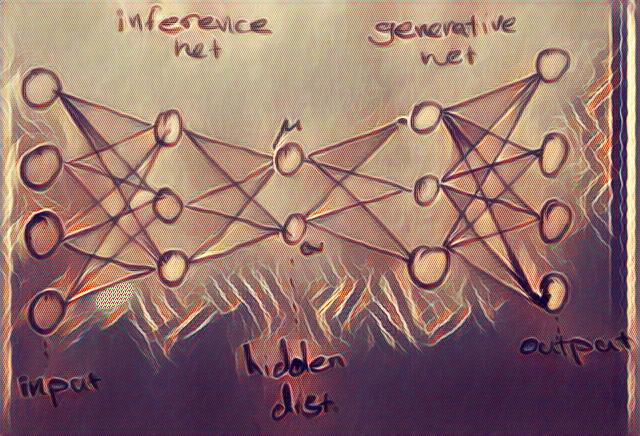

In order to be able to use stochastic gradient descent with this autoencoder network, we need to be able to calculate gradients w.r.t. all the nodes in the network. However, latent variables, z, in a graphical model are random variables (distributions) which are not differentiable. Therefore, to make it differentiable, we treat the mean and variances of the distributions as simple deterministic parameters and multiply the variance by a sample from a normal noise generator to add randomness. By parameterizing the hidden distribution this way, we can back-propagate the gradient to the parameters of the encoder and train the whole network with stochastic gradient descent. This procedure will allow us to learn mean and variance values for the hidden code and it’s called the “re-parameterization trick”. It is important to appreciate the importance of the fact that the whole network is now differentiable. This means that optimization techniques can now be used to solve the inference problem efficiently.

In classic version of neural networks we could simply measure the error of network outputs with desired target value using a simple mean square error. But now that we are dealing with distributions, MSE is no longer a good error metric. So instead, loosely speaking, we use another metric for measuring the difference between two distributions i.e. KL-Divergence. It turns out that this distance between our variational approximate and the real posterior distribution is not very easy to minimize either. However, using some simple math, we can show that this distance is always positive and that it comprises of two main parts (probability of data minus a function called ELBO). So instead of minimizing the whole thing, we can maximize the smaller term (ELBO). This term comes from marginalizing the log-probability of data and is always smaller than the log probability of the data. That’s why we call it a lower bound on the evidence (data given model). From the perspective of autoencoders, the ELBO function can be seen as the sum of the reconstruction cost of the input plus the regularization terms.

If after maximizing the ELBO, the lower bound of data is close to the data distribution, then the distance is close to zero and voila!; We have minimized the error distance indirectly. The algorithm we use to maximize the lower bound is the exact opposite of gradient descent. Instead of going in the reverse direction of the gradient to get to the minimum, we go toward the positive direction to get to the maximum, so it’s now called gradient ascent! This whole algorithm is called “autoencoding variational Bayes”! After we are done with the learning we can visualize the latent space of our VAE and generate samples from it. Pretty cool, eh!?

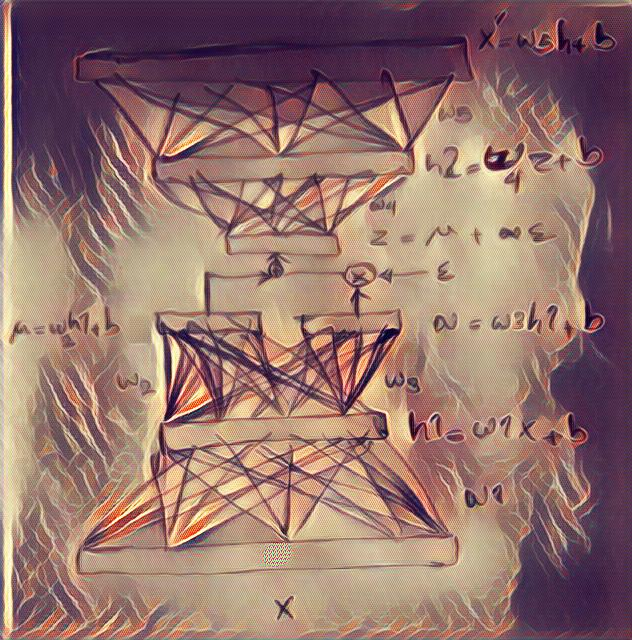

#### Import Keras and other necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import SVG

from sklearn import preprocessing, metrics, neighbors, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, cohen_kappa_score,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score, log_loss)

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint, TensorBoard
from keras.utils.vis_utils import model_to_dot, plot_model, pydot

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN

Using TensorFlow backend.
C:\Users\sushant_singh01\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
np.random.seed(42)

#### Read data set:

In [3]:
#read the dataset
csv = pd.read_csv("C:/Users/sushant_singh01/Documents/Python Scripts/Data/creditcard.csv")
csv.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Prepare training, validation and test datasets:

In [4]:
data = csv.astype('float32').copy()
data.sort_values('Time', inplace=True)

In [5]:
# Applying Standard Scalar on Amount attribute
#scaler = preprocessing.StandardScaler()
#data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
#data['Amount'].head()

In [6]:
#x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,1:-1], data['Class'], test_size=0.3, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [7]:
data.iloc[:,1:-1].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998


In [8]:
# Here the stratified shuffle split is done
X = data.iloc[:,1:-1]
Y = data['Class']

# have used 50 splits and test data proportion equal to 0.2
sss= StratifiedShuffleSplit(n_splits=50, test_size=0.3, random_state=42)

# equating the index of all the shuffled index to the data.
for train_index, test_index in sss.split(X, Y):                           
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]            
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        
X1 = x_test
Y1 = y_test

sss1= StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
# equating the index of all the shuffled index to the data.
for test_index, val_index in sss1.split(X1, Y1):                           
        x_test, x_val = X1.iloc[test_index], X1.iloc[val_index]            
        y_test, y_val = Y1.iloc[test_index], Y1.iloc[val_index]

In [9]:
#Applying Standard Scaler to bring all the train, validation & test input atrributes under single scale
#scaler = preprocessing.StandardScaler()
scaler = preprocessing.RobustScaler()
x_train, x_test, x_val = scaler.fit_transform(x_train), scaler.fit_transform(x_test), scaler.fit_transform(x_val)

In [10]:
print ('Input Shape: ', data.shape)

Input Shape:  (284807, 31)


In [11]:
print ('train Shape: ', x_train.shape, y_train.shape)
print ('test Shape: ', x_test.shape, y_test.shape)
print ('val Shape: ', x_val.shape, y_val.shape)

train Shape:  (199364, 29) (199364,)
test Shape:  (68354, 29) (68354,)
val Shape:  (17089, 29) (17089,)


In [12]:
pd.value_counts(y_train)

0.0    199020
1.0       344
Name: Class, dtype: int64

Apply over sampling technique SMOTE, SMOTEENN, SMOTETomek or ADASYN on train dataset:

In [13]:
#So far SMOTE is better, still need to try SMOTEENN once
#smote = SMOTE(ratio='minority', random_state=42, kind='svm')
#smote = SMOTEENN(ratio='minority', random_state=42)
smote = SMOTEENN(random_state=42, n_jobs=16)
x_train_en, y_train_en = smote.fit_sample(x_train, y_train)
#plot_2d_space(x_train, y_train, 'SMOTE over-sampling')

x_train = x_train_en
y_train = y_train_en

C:\Users\sushant_singh01\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\sushant_singh01\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [14]:
print ('train Shape: ', x_train.shape, y_train.shape)
print ('test Shape: ', x_test.shape, y_test.shape)
print ('val Shape: ', x_val.shape, y_val.shape)

train Shape:  (397532, 29) (397532,)
test Shape:  (68354, 29) (68354,)
val Shape:  (17089, 29) (17089,)


In [15]:
#print (y_train.value_counts())
print (np.count_nonzero(y_train))
print (y_test.value_counts())
print (y_val.value_counts())

199020
0.0    68236
1.0      118
Name: Class, dtype: int64
0.0    17059
1.0       30
Name: Class, dtype: int64


### Building the VAE model:

#### First, let’s implement the encoder net Q(z|X), which takes input X and outputting two things: μ(X) and Σ(X), the parameters of the Gaussian.

That is, our Q(z|X) is a neural net with one hidden layer. In this implementation, our latent variable is two dimensional, so that we could easily visualize it. In practice though, more dimension in latent variable should be better.

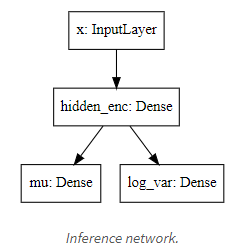

In [16]:
hidden_size = 16 #size of the hidden layer in encoder and decoder
latent_dim = 2 #number of latent variables to learn

input_dim = x_train.shape[1]

# input layer
input_layer = Input(shape=(input_dim,))

# hidden layer
encoder_hidden = Dense(hidden_size, activation='relu' , name='encoder_hidden')(input_layer)
#encoder_hidden = BatchNormalization()(input_layer)
#encoder_hidden = Dense(hidden_size, activation='relu' , name='encoder_hidden')(encoder_hidden)
#encoder_hidden = BatchNormalization()(encoder_hidden)

# output layer for mean and log variance
z_mean = Dense(latent_dim, name='z_mean')(encoder_hidden)
z_log_var = Dense(latent_dim, name='z_log_var')(encoder_hidden)

However, we are now facing a problem. How do we get z from the encoder outputs? Obviously we could sample z from a Gaussian which parameters are the outputs of the encoder. Alas, sampling directly won’t do, if we want to train VAE with gradient descent as the sampling operation doesn’t have gradient!

There is, however a trick called reparameterization trick, which makes the network differentiable. Reparameterization trick basically divert the non-differentiable operation out of the network, so that, even though we still involve a thing that is non-differentiable, at least it is out of the network, hence the network could still be trained.

The reparameterization trick is as follows. 
Recall, if we have x∼N(μ,Σ) and then standardize it so that μ=0,Σ=1 we could revert it back to the original distribution by reverting the standardization process. Hence, we have this equation:
x=μ+Σpow(1/2)xstd

With that in mind, we could extend it. If we sample from a standard normal distribution, we could convert it to any Gaussian we want if we know the mean and the variance. Hence we could implement our sampling operation of z by:

z=μ(X)+Σpow(1/2)(X)ϵ
where ϵ∼N(0,1).

Now, during backpropagation, we don’t care anymore with the sampling process, as it is now outside of the network, i.e. doesn’t depend on anything in the net, hence the gradient won’t flow through it.

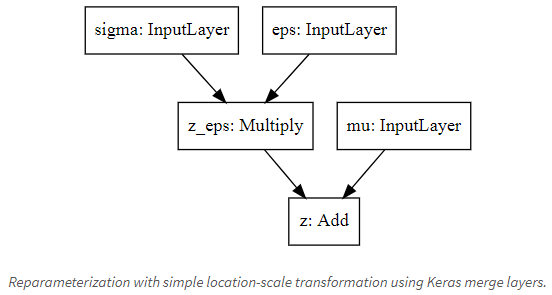

In [17]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Sample z ~ Q(z|X)
z = Lambda(sampling, name='z_sampled')([z_mean, z_log_var])

Now we create the decoder net P(X|z):

In [18]:
# P(X|z) -- decoder
decoder_hidden = Dense(hidden_size, activation='relu', name='decoder_hidden')
decoded_mean = Dense(input_dim, activation=None, name='decoded_mean')

Define a separate Decoder model, that reconstruct data from latent variable. 
The decoder model uses weights that was trained with the VAE model. 
We need a separate model, if we want to generate data from given data in latent space.

In [19]:
# Generator model, generate new data given latent variable z
d_in = Input(shape=(latent_dim,), name='decoder_input')
d_h = decoder_hidden(d_in)
d_out = decoded_mean(d_h)
decoder = Model(d_in, d_out, name='decoder')

Now create the output layer

In [20]:
h_p = decoder_hidden(z)
output_layer = decoded_mean(h_p)

Lastly, from this model, we can do three things: reconstruct inputs, encode inputs into latent variables, and generate data from latent variable. So, we have three Keras models:

In [21]:
# Overall VAE model, for reconstruction and training
vae = Model(input_layer, output_layer)

# Encoder model, to encode input into latent variable. We use the mean as the output as it is the center point, 
#the representative of the gaussian.
encoder = Model(input_layer, z_mean)

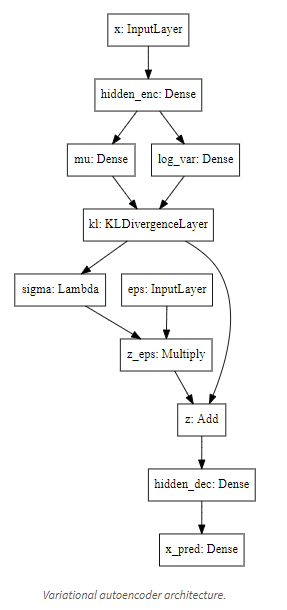

Then, we need to translate our loss into Keras code. Calculate VAE loss = reconstruction loss + KL loss for each data in minibatch.

In [22]:
def rec_loss(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred), axis=-1)

def kl_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(y_true, y_pred):
    rec_loss = K.sum(K.square(y_true - y_pred), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean((rec_loss + kl_loss) / 2)

Now, compile your model & print the summary

In [23]:
#vae.compile(optimizer=Adam(lr=1e-2), loss=vae_loss, metrics=[rec_loss, kl_loss, 'accuracy'])
#vae.compile(optimizer=Adam(lr=1e-2, decay=1e-5), loss=vae_loss, metrics=[rec_loss, kl_loss])
#vae.compile(optimizer=RMSprop(lr=1e-2, decay=1e-5), loss=vae_loss, metrics=[rec_loss, kl_loss])
vae.compile(optimizer=Adam(), loss=vae_loss, metrics=[rec_loss, kl_loss])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
encoder_hidden (Dense)          (None, 16)           480         input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          encoder_hidden[0][0]             
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            34          encoder_hidden[0][0]             
__________________________________________________________________________________________________
z_sampled 

Define a class to save best VAE, encoder and decoder models

In [24]:
#Checkpoint to save best model
vlos = float(10000.)

class SaveBest(Callback):
    global vlos
    vlos = float(10000.)

    def on_epoch_end(self, batch, logs={}):
        global vlos
        tmp = logs.get('val_loss')
        if (tmp==None):
            tmp = 1000.
        
        if (vlos - float(tmp) > 0.000001) :
            print ('loss improved from: ', vlos, ' to: ', tmp, 'saving models')
            vlos = float(tmp)
            encoder.save('best_encoder1.h5')
            decoder.save('best_decoder1.h5')
            vae.save('best_vae1.h5')

#Create the object so that it can be used in callbacks            
savebest = SaveBest()

Plot Model Visualization to validate

In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/sushant_singh01/graphviz-2.38/release/bin/'

In [36]:
#SVG(model_to_dot(vae, show_shapes='true').create(prog='pydotplus', format='svg'))
plot_model(vae, to_file='vae_plot.png', show_shapes=True, show_layer_names=True)

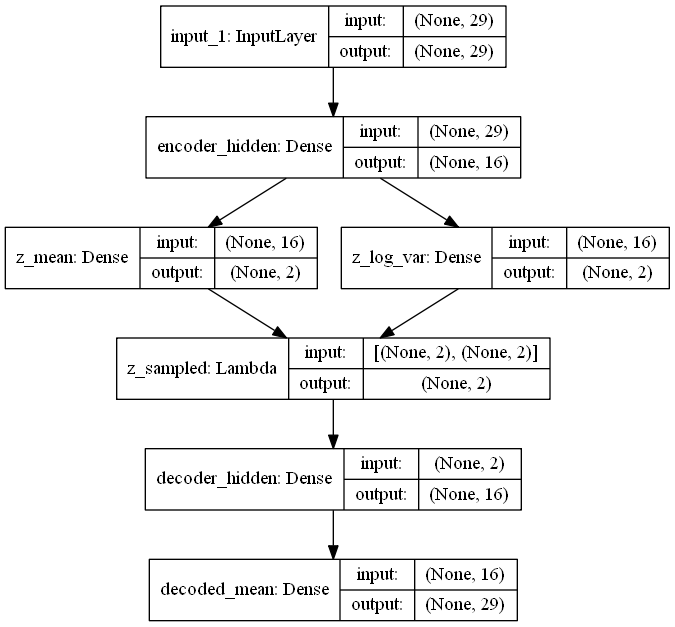

Train the model with early stopping and a kind of learning rate schedule for the specified number of epochs with the specified batch size:

In [26]:
n_epochs = 200
batch_size = 32

#Checkpoint to save best model
#checkpointer = ModelCheckpoint(filepath="VAEmodel.h5", verbose=0, save_best_only=True)

#Save tensorboard events
tensorboard = TensorBoard(log_dir='C:/tmp/Anamoly/VAE/',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

#stop training if loss does not decrease with at least 0.00001
early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=1e-5) 

#reduce learning rate (divide it by 5 = multiply it by 0.2) if loss does not decrease with at least 0.00001
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, min_delta=1e-5, factor=0.2) 

callbacks = [early_stopping, reduce_lr, savebest, tensorboard]

#collect training data in history object
history = vae.fit(x_train, x_train, 
                  validation_data=(x_test, x_test), 
                  batch_size=batch_size, 
                  shuffle=True,
                  epochs=n_epochs,
                  callbacks=callbacks)

Train on 397532 samples, validate on 68354 samples
Epoch 1/200
397532/397532 [==============================] - 33s 83us/step - loss: 1497.1509 - rec_loss: 2343.4080 - kl_loss: 650.8936 - val_loss: 27.8172 - val_rec_loss: 52.2222 - val_kl_loss: 3.4123
loss improved from:  10000.0  to:  27.817228830805586 saving models
Epoch 2/200
397532/397532 [==============================] - 30s 75us/step - loss: 39.2354 - rec_loss: 72.2761 - kl_loss: 6.1947 - val_loss: 26.4580 - val_rec_loss: 49.1082 - val_kl_loss: 3.8079
loss improved from:  27.817228830805586  to:  26.45804481725115 saving models
Epoch 3/200
397532/397532 [==============================] - 31s 79us/step - loss: 35.0789 - rec_loss: 63.9755 - kl_loss: 6.1823 - val_loss: 24.5181 - val_rec_loss: 45.0981 - val_kl_loss: 3.9381
loss improved from:  26.45804481725115  to:  24.51807792411992 saving models
Epoch 4/200
397532/397532 [==============================] - 32s 80us/step - loss: 31.5561 - rec_loss: 56.7409 - kl_loss: 6.3713 - val_

Epoch 78/200
397532/397532 [==============================] - 27s 69us/step - loss: 23.5804 - rec_loss: 41.1937 - kl_loss: 5.9671 - val_loss: 21.4894 - val_rec_loss: 38.7706 - val_kl_loss: 4.2082
Epoch 79/200
397532/397532 [==============================] - 28s 70us/step - loss: 23.5632 - rec_loss: 41.1585 - kl_loss: 5.9679 - val_loss: 21.5262 - val_rec_loss: 38.8551 - val_kl_loss: 4.1973
Epoch 80/200
397532/397532 [==============================] - 27s 69us/step - loss: 23.5556 - rec_loss: 41.1460 - kl_loss: 5.9652 - val_loss: 21.5261 - val_rec_loss: 38.8488 - val_kl_loss: 4.2033
Epoch 81/200
397532/397532 [==============================] - 28s 70us/step - loss: 23.5442 - rec_loss: 41.1196 - kl_loss: 5.9689 - val_loss: 21.5011 - val_rec_loss: 38.8164 - val_kl_loss: 4.1858
Epoch 82/200
397532/397532 [==============================] - 28s 69us/step - loss: 23.5583 - rec_loss: 41.1413 - kl_loss: 5.9754 - val_loss: 21.8855 - val_rec_loss: 39.5925 - val_kl_loss: 4.1786
Epoch 83/200
397532/

Epoch 120/200
397532/397532 [==============================] - 29s 72us/step - loss: 23.4027 - rec_loss: 40.8663 - kl_loss: 5.9391 - val_loss: 21.5830 - val_rec_loss: 38.9546 - val_kl_loss: 4.2115
Epoch 121/200
397532/397532 [==============================] - 28s 71us/step - loss: 23.3569 - rec_loss: 40.7684 - kl_loss: 5.9455 - val_loss: 21.4866 - val_rec_loss: 38.7871 - val_kl_loss: 4.1862
Epoch 122/200
397532/397532 [==============================] - 27s 69us/step - loss: 23.3957 - rec_loss: 40.8474 - kl_loss: 5.9440 - val_loss: 21.5938 - val_rec_loss: 38.9746 - val_kl_loss: 4.2129
Epoch 123/200
397532/397532 [==============================] - 27s 68us/step - loss: 23.3532 - rec_loss: 40.7599 - kl_loss: 5.9465 - val_loss: 21.5328 - val_rec_loss: 38.8962 - val_kl_loss: 4.1694
Epoch 124/200
397532/397532 [==============================] - 28s 71us/step - loss: 23.3545 - rec_loss: 40.7714 - kl_loss: 5.9376 - val_loss: 21.5795 - val_rec_loss: 38.9744 - val_kl_loss: 4.1846
Epoch 125/200
3

Plotting training and validation loss:

In [27]:
#fig = plt.figure(figsize=(14, 6))
#ax = fig.gca()
#ax.plot(history.history['rec_loss']);
#ax.plot(history.history['val_rec_loss']);

In [28]:
def draw_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()  

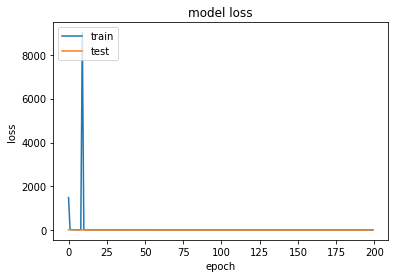

In [29]:
draw_history(history, 'loss')

Plotting the learned latent representations for normal and anomalous instances in the specified dataset (training/validation/test):

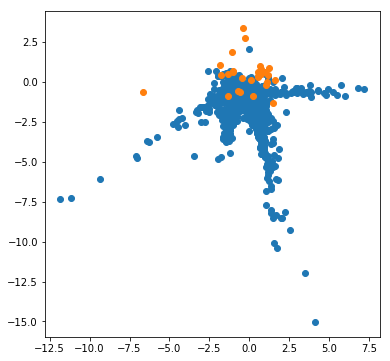

In [30]:
x_data = x_val
y_data = y_val

with_labels = np.concatenate([x_data, np.reshape(np.ravel(y_data), (-1, 1))], axis=1) #concatenate x and y to be able to filter by class

normal = with_labels[np.where(with_labels[:, -1] == 0)] #filter normal instances
anomalous = with_labels[np.where(with_labels[:, -1] == 1)] #filter anomalous instances

#normal_encoded = encoder.predict(normal[:, :-1], batch_size=128)
normal_encoded = encoder.predict(normal[:, :-1], batch_size=batch_size)
#anomalous_encoded = encoder.predict(anomalous[:, :-1], batch_size=128)
anomalous_encoded = encoder.predict(anomalous[:, :-1], batch_size=batch_size)

fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

#semicolon at the end hides unnecessary output
ax.scatter(normal_encoded[:, 0], normal_encoded[:, 1]);
ax.scatter(anomalous_encoded[:, 0], anomalous_encoded[:, 1]);


Apply simple Linear Discriminant Analysis to learned features (the latent representations):

In [31]:
#with_labels_encoded = encoder.predict(with_labels[:, :-1], batch_size=128)
with_labels_encoded = encoder.predict(with_labels[:, :-1], batch_size=batch_size)

X = with_labels_encoded
y = with_labels[:, -1]

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

pred = clf.predict(X)

print("AUC(ROC): " + str(metrics.roc_auc_score(y, pred)))
print("Precision: " + str(metrics.precision_score(y, pred)))
print("Recall: " + str(metrics.recall_score(y, pred)))
print("F1 score: " + str(metrics.f1_score(y, pred)))

tn, fp, fn, tp = metrics.confusion_matrix(y, pred).ravel()

print("False positives: " + str(fp))
print("True positives: " + str(tp))
print("False negatives: " + str(fn))
print("True negatives: " + str(tn))

AUC(ROC): 0.6991500087930125
Precision: 0.2926829268292683
Recall: 0.4
F1 score: 0.3380281690140845
False positives: 29
True positives: 12
False negatives: 18
True negatives: 17030


In [32]:
metrics.confusion_matrix(y, pred)

array([[17030,    29],
       [   18,    12]], dtype=int64)

In [33]:
print (classification_report(y, pred, target_names=['class 0','class 1']))
acc = accuracy_score(y, pred)
Accuracy = acc*100
print('Accuracy =',Accuracy)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00     17059
    class 1       0.29      0.40      0.34        30

avg / total       1.00      1.00      1.00     17089

Accuracy = 99.72496927848323


### Reconstruction error

We can see that distribution of reconstruction error is different bwtween Normal and Fraud cases, but the difference is not big enought to perform classification

C:\Users\sushant_singh01\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Reconstruction error - Train set')

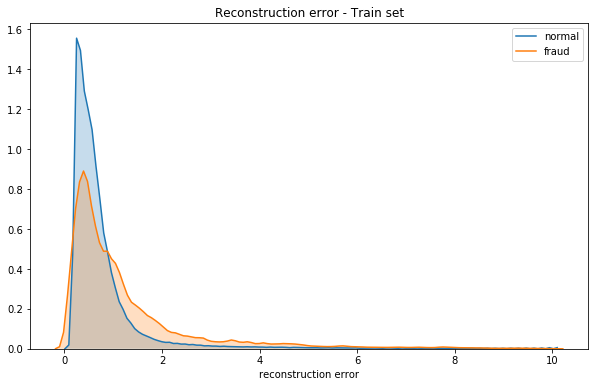

In [34]:
x_train_encoded = encoder.predict(x_train)

pred_train = decoder.predict(x_train_encoded)
mse = np.mean(np.power(x_train - pred_train, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse, 'Class': y_train})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.Class==0], label='normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.Class==1], label='fraud', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');
plt.title('Reconstruction error - Train set')

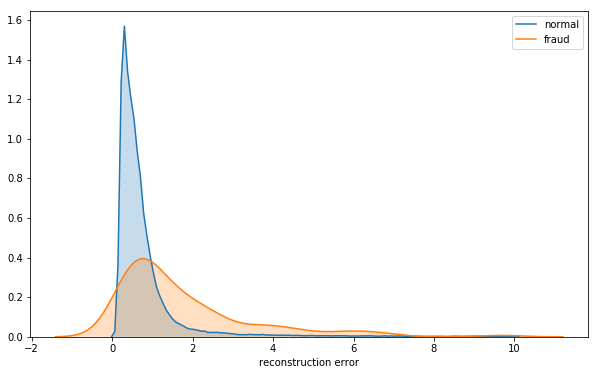

In [35]:
x_test_encoded = encoder.predict(x_test)

pred_test = decoder.predict(x_test_encoded)
mseT = np.mean(np.power(x_test - pred_test, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mseT, 'Class': y_test})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.Class==0], label='normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.Class==1], label='fraud', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');

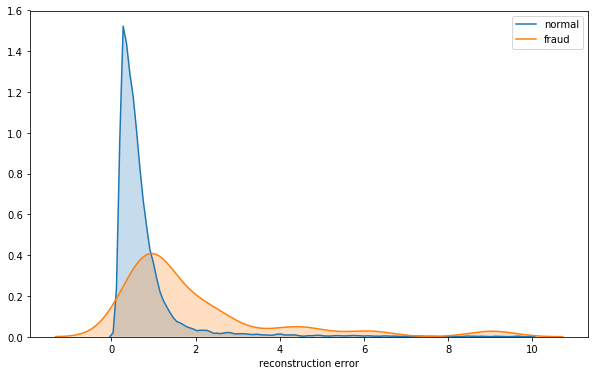

In [36]:
x_val_encoded = encoder.predict(x_val)

pred_val = decoder.predict(x_val_encoded)
mseV = np.mean(np.power(x_val - pred_val, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mseV, 'Class': y_val})

plt.figure(figsize=(10,6))
sns.kdeplot(error_df.recon_error[error_df.Class==0], label='normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.recon_error[error_df.Class==1], label='fraud', shade=True, clip=(0,10))
plt.xlabel('reconstruction error');

In [37]:
# this function returns a plot of Recall vs threshold/ Precision vs threshold with the point of intersection of two curves
def reconstruction(x_val, y_val):
    precision, recall, th = precision_recall_curve(error_df.Class, error_df.recon_error) # finding the precision, recall and threshold using  precision_recall_curve function
    plt.plot(th, precision[1:], 'b', label='Precision curve') # ploting the curve for Precision  
    plt.plot(th, recall[1:], 'r', label='Recall curve')       # plotting the curve for recall
    plt.title('Recall vs threshold/ Precision vs threshold ') # setting the title
    plt.xlabel('threshold')                                   # setting the x-label
    plt.ylabel('Precision/ Recall')                           # setting the y-label
    plt.legend()                                              # setting the legend
    
    idx = np.argwhere(np.diff((precision[1:] - recall[1:]) == 0))      # finding the index of the point of intersection of both the curves
    plt.plot(th[idx], precision[1:][idx],"yo", label = 'Intersection') # making a yellow dot on the point of intersection
    plt.show()                                                         
    return(th[idx], precision[1:][idx])

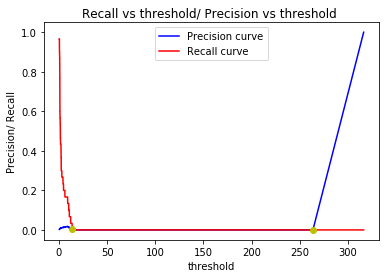

(array([[ 13.61043152],
        [263.76632407]]), array([[0.00549451],
        [0.        ]]))

In [38]:
reconstruction(x_val, y_val)

### Latent space
* We can see that Fraud and Normal cases, can be separable at latent space.

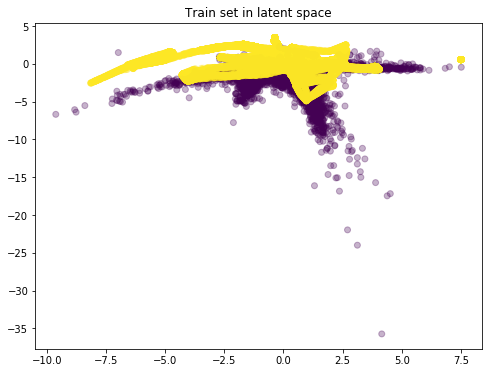

In [39]:
x_train_encoded = encoder.predict(x_train)

plt.figure(figsize=(8, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train, alpha=0.3)
plt.title('Train set in latent space')
plt.show()

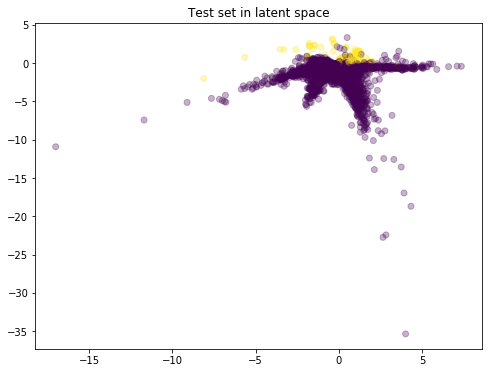

In [40]:
x_test_encoded = encoder.predict(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, alpha=0.3)

plt.title('Test set in latent space')
plt.show()

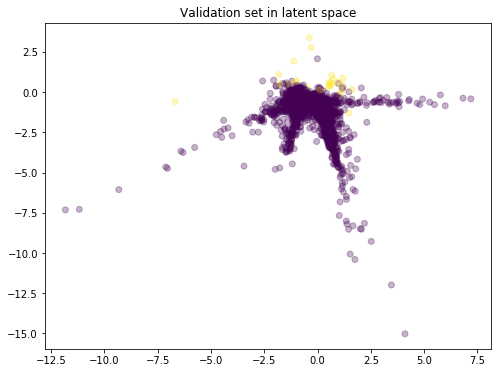

In [41]:
x_val_encoded = encoder.predict(x_val)

plt.figure(figsize=(8, 6))
plt.scatter(x_val_encoded[:, 0], x_val_encoded[:, 1], c=y_val, alpha=0.3)

plt.title('Validation set in latent space')
plt.show()

### Lest classify in Latent spacw
* Any classification method can be used, lets try nearest neighbour
* Playing with classification parameter to get best prediction on Validation set

#### More on K
You’re probably wondering how to pick the variable K and what its effects are on your classifier. Well, like most machine learning algorithms, the K in KNN is a hyperparameter that you, as a designer, must pick in order to get the best possible fit for the data set. Intuitively, you can think of K as controlling the shape of the decision boundary we talked about earlier.

When K is small, we are restraining the region of a given prediction and forcing our classifier to be “more blind” to the overall distribution. A small value for K provides the most flexible fit, which will have low bias but high variance. Graphically, our decision boundary will be more jagged.

On the other hand, a higher K averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries which means lower variance but increased bias.

(If you want to learn more about the bias-variance tradeoff, check out Scott Roe’s Blog post. You can mess around with the value of K and watch the decision boundary change!)

Reference: https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

Text(0.5, 1.0, "2-Class classification (k = 1, weights = 'uniform')")

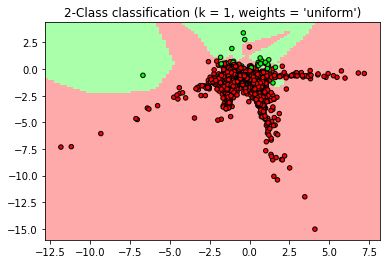

In [57]:
weights='uniform'
#n_neighbors=27
n_neighbors=1
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
#clf = svm.OneClassSVM()
X=x_val_encoded
y=y_val
clf.fit(X, y)

h=0.2
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))

### Prediction on validation set

In [58]:
def draw_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve - Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();

In [59]:
def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    #ll = log_loss(ytest, ypred)
    #print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

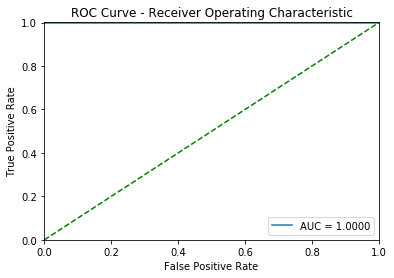

Accuracy: 1.00000, Cohen's Kappa Score: 1.00000
 
Confusion Matrix:
[[17059     0]
 [    0    30]]
Classification Report:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     17059
        1.0       1.00      1.00      1.00        30

avg / total       1.00      1.00      1.00     17089



In [60]:
x_val_encoded = encoder.predict(x_val)

y_val_neighbour = clf.predict(x_val_encoded)
draw_roc_curve(y_val, y_val_neighbour)

print_stats(y_val, y_val_neighbour)

In [61]:
print('Total no. of Frauds in train data: ', pd.value_counts(y_train)[1], 'out of ', pd.value_counts(y_train)[0]+pd.value_counts(y_train)[1])
print('Total no. of Frauds in val data: ', y_val.value_counts()[1], 'out of ', y_val.count())
print('Total no. of Frauds in test data: ', y_test.value_counts()[1], 'out of ', y_test.count())

Total no. of Frauds in train data:  199020 out of  397532
Total no. of Frauds in val data:  30 out of  17089
Total no. of Frauds in test data:  118 out of  68354


#### The results are not bad, lets try improve then by adding reconstruction error, to the classification. Note: not needed when it's already good.

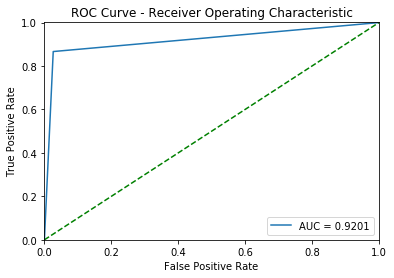

Accuracy: 0.97343, Cohen's Kappa Score: 0.09979
 
Confusion Matrix:
[[16609   450]
 [    4    26]]
Classification Report:
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99     17059
        1.0       0.05      0.87      0.10        30

avg / total       1.00      0.97      0.98     17089



In [73]:
weights='uniform'
n_neighbors=3

clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

#X=np.concatenate((x_train_encoded, np.reshape(mse, (mse.shape[0],1))), axis=1)
X=np.concatenate((x_train_encoded, np.reshape(np.ravel(mse), (-1,1))), axis=1)

y=y_train

clf.fit(X, y)
x_val_encoded = encoder.predict(x_val)

#vals = np.concatenate((x_val_encoded, np.reshape(mseV, (mseV.shape[0],1))), axis=1)
vals = np.concatenate((x_val_encoded, np.reshape(np.ravel(mseV), (-1,1))), axis=1)

y_val_neighbour = clf.predict(vals)
draw_roc_curve(y_val, y_val_neighbour)

print_stats(y_val, y_val_neighbour)

In [74]:
pfpr, ptpr, pthresholds = roc_curve(y_val, y_val_neighbour)
print (pthresholds)

[2. 1. 0.]


In [75]:
y_val.count()

17089